Here is a training pipeline to classify cats and dogs using three NN.

What is below?
- 🪇 Add libraries and training pipeline [train()].
- 🪻 Choose a model (EfficientNet, RegNet, VIT) and run train(), intermediate metrics will be stored in TensorBoard.

If you are curious about Class Activation Map please see it at the end.

# 🪇 Set up

## Libs

In [1]:
# Standard 
import os
import random
import glob
import time
import numpy as np
from PIL import Image
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# PyTorch Vision 
import torchvision
import torchvision.transforms as transforms

# Models and Grad-CAM
import timm
from efficientnet_pytorch import EfficientNet
from vit_pytorch.efficient import ViT
from linformer import Linformer
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Scikit-learn for metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Visualization 
import matplotlib.pyplot as plt

# Device Configuration (CPU/GPU)
# Uncomment depending on the device availability
# device = ("cuda" if torch.cuda.is_available() else "cpu")
# device = ("mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#os.chdir('/Users/lune/ISP/rolling-in-the-deep/')
os.getcwd()

'/Users/lune/ISP/rolling-in-the-deep'

## Training pipeline

In [6]:
def train(data_dir, data_subset_size, data_train_fraction, data_augmentation, dataloader_batch_size, dataloader_num_workers, train_model, train_num_epochs, train_learning_rate, train_tensorboard, train_tensorboard_dir):

    # ⚙️ Settings #############################################################################################################
    ## Seed
    seed_everything(seed = 42)
    ## Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #📍 Tensorboard
    if train_tensorboard:
        writer = SummaryWriter(train_tensorboard_dir)


    # 🗂 Dataset ##############################################################################################################
    ## Dataset--------------------------------------------------------------------------
    dataset = torchvision.datasets.ImageFolder(data_dir)

    ## Subset
    indices = torch.randperm(len(dataset)).tolist()
    subset_indices = indices[:data_subset_size]
    subset_dataset = torch.utils.data.Subset(dataset, subset_indices)

    ## Split
    train_size = int(data_train_fraction * len(subset_dataset))  # 80% for training
    val_size = len(subset_dataset) - train_size   # 20% for validation
    train_dataset, val_dataset = torch.utils.data.random_split(subset_dataset, [train_size, val_size])

    ## Augmentation

    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                             ])

    transform_augmented = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize
            transforms.RandomHorizontalFlip(),                    # Randomly flip images horizontally
            transforms.RandomRotation(15),                        # Randomly rotate within ±15 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color adjustments
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to pre-trained model standards
        ])

    if data_augmentation:
        train_dataset = torch.utils.data.Subset(torchvision.datasets.ImageFolder(data_dir, transform=transform_augmented), train_dataset.indices)
        val_dataset = torch.utils.data.Subset(torchvision.datasets.ImageFolder(data_dir, transform=transform), val_dataset.indices)
    else:
        train_dataset = torch.utils.data.Subset(torchvision.datasets.ImageFolder(data_dir, transform=transform), train_dataset.indices)
        val_dataset = torch.utils.data.Subset(torchvision.datasets.ImageFolder(data_dir, transform=transform), val_dataset.indices)


    ## DataLoader--------------------------------------------------------------------------
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=dataloader_batch_size, shuffle=True, num_workers=dataloader_num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=dataloader_batch_size, shuffle=False, num_workers=dataloader_num_workers)  

    #📍 Tensorboard (one batch)
    if train_tensorboard:
        examples = iter(train_loader)
        example_data, example_labels = next(examples)

    #📍 Tensorboard 
    if train_tensorboard:
        img_grid = torchvision.utils.make_grid(example_data, nrow=4, normalize=True)
        writer.add_image('train/img_1st_batch', img_grid)


    # 🪷 Model #################################################################################################################
    ## Model-------------------------------------------------------------------------------
    model = train_model
    model.to(device)

    ### Model info
    params = list(model.parameters())
    num_tr_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB
    print(f'{num_tr_params} train parameters in {len(params)} groups, model size is {model_size:.1f} MB')

    #📍 Tensorboard
    if train_tensorboard:
        writer.add_graph(model, example_data.to(device))
        writer.add_text('model_info', f'{num_tr_params} train parameters in {len(params)} groups, model size is {model_size:.1f} MB')

    
    ## Training hyperparameters-------------------------------------------------------------
    ### Criterion (Loss)
    criterion = torch.nn.CrossEntropyLoss()
    ### Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=train_learning_rate) 
    ### Scheduler
    sch_gamma = 0.1
    sch_step_size = 5
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=sch_step_size, gamma=sch_gamma)



    # 🪻 Training ##############################################################################################################
    for epoch in range(train_num_epochs):
        print(f'Epoch {epoch+1}')

        # Training loop----------------------------------------------------------------
        start_time = time.time()

        model.train() 

        running_loss = 0.0
        all_preds = []
        all_labels = []

        for batch, (inputs, labels) in enumerate(tqdm(train_loader)):

            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            optimizer.zero_grad() # clears old gradients 
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 

            # backward pass
            loss.backward() # compute the gradient
            optimizer.step() # updates the models weights using the gradient

            # record metrics (loss and prediction)
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # epoch metrics
        loss = running_loss / len(train_loader)
        accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        running_loss = 0.0 
        all_preds = []
        all_labels = []

        end_time = time.time()
        inference_time = (end_time - start_time)/60

        print(f'[Epoch {epoch+1}/{train_num_epochs}, Training loss: {loss:.3f}, accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, time: {inference_time:.1f} min')

        # 📍 Tensorboard
        if train_tensorboard:
            writer.add_scalar('train/loss', loss, epoch+1)
            writer.add_scalar('train/accuracy' , accuracy, epoch+1)
            writer.add_scalar('train/precision', precision, epoch+1)
            writer.add_scalar('train/recall' , recall, epoch+1)
            writer.add_scalar('train/f1', f1, epoch+1)
            writer.add_scalar('train/time', inference_time, epoch+1)
                
            #probability
            #writer.add_figure('probability',
            #                   plot_classes_preds(model, inputs, labels),
            #                   global_step=epoch)  

            #for name, param in model.named_parameters():
            #    if param.requires_grad:
            #        layer_name = name
            #        writer.add_histogram(f'{layer_name}/weights', param, epoch+1)
            #        writer.add_histogram(f'{layer_name}/gradients', param.grad, epoch+1)

        # Validation loop----------------------------------------------------------------
        model.eval()

        running_loss = 0.0
        all_preds = []
        all_labels = []

        # 📍 Tensorboard misclassified
        if train_tensorboard:
            misclassified_images = []
            misclassified_labels = []

        with torch.no_grad():
            for batch, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs, labels = inputs.to(device), labels.to(device)

                # forward pass
                outputs = model(inputs) 
                loss = criterion(outputs, labels) 

                # record metrics (loss and prediction)
                running_loss += loss.item()
                _, preds = torch.max(outputs.data, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # 📍 Tensorboard misclassified
                if train_tensorboard:
                    misclassified_mask = preds != labels
                    if misclassified_mask.sum() > 0:
                        misclassified_images.extend(inputs[misclassified_mask].cpu())
                        misclassified_labels.extend(preds[misclassified_mask].cpu().numpy())

        loss = running_loss / len(val_loader)
        accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        running_loss = 0.0 
        all_preds = []
        all_labels = []

        print(f'[Epoch {epoch + 1}/{train_num_epochs}, Validation loss: {loss:.3f}, accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}')

        # 📍 Tensorboard
        if train_tensorboard:
            writer.add_scalar('val/loss', loss, epoch+1)
            writer.add_scalar('val/accuracy' , accuracy, epoch+1)
            writer.add_scalar('val/precision', precision, epoch+1)
            writer.add_scalar('val/recall' , recall, epoch+1)
            writer.add_scalar('val/f1', f1, epoch+1)

            if len(misclassified_images) > 0:
                grid = torchvision.utils.make_grid(misclassified_images, nrow=4, normalize=True)
                writer.add_image(f'val/misclassified_images/epoch_{epoch+1}', grid, epoch+1)

        scheduler.step() # adjust the learning rate
        
    writer.close()

# 🪻 Training

In [7]:
cur_epochs = 10
cur_subset = 300

## EfficientNet

### b0

In [ ]:
#print(timm.list_models('*efficientnet_b*'))

In [67]:
# EfficientNet
model = timm.create_model('efficientnet_b0', pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

train(data_dir='/Users/lune/ISP/rolling-in-the-deep/Datasets/kagglecatsanddogs_5340/PetImages', 
      data_subset_size=cur_subset, 
      data_train_fraction=0.8, 
      data_augmentation=True,
      dataloader_batch_size=32, 
      dataloader_num_workers=4, 
      train_model = model,
      train_num_epochs=cur_epochs, 
      train_learning_rate=0.001, 
      train_tensorboard=True,
      train_tensorboard_dir='Catsdogs/runs_W4/EfficientNet_b0'
      )

4010110 train parameters in 213 groups, model size is 15.3 MB
Epoch 1


100%|██████████| 8/8 [01:15<00:00,  9.43s/it]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 1/20, Training loss: 0.214, accuracy: 0.925, precision: 0.500, recall: 0.463, f1: 0.481, time: 1.3 min


100%|██████████| 2/2 [00:18<00:00,  9.07s/it]


[Epoch 1/20, Validation loss: 0.001, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 2


100%|██████████| 8/8 [01:12<00:00,  9.06s/it]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 2/20, Training loss: 0.009, accuracy: 0.996, precision: 0.500, recall: 0.498, f1: 0.499, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.96s/it]


[Epoch 2/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 3


100%|██████████| 8/8 [01:13<00:00,  9.25s/it]


[Epoch 3/20, Training loss: 0.001, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:18<00:00,  9.08s/it]


[Epoch 3/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 4


100%|██████████| 8/8 [01:14<00:00,  9.26s/it]


[Epoch 4/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.90s/it]


[Epoch 4/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 5


100%|██████████| 8/8 [01:12<00:00,  9.08s/it]


[Epoch 5/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:18<00:00,  9.09s/it]


[Epoch 5/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 6


100%|██████████| 8/8 [01:11<00:00,  9.00s/it]


[Epoch 6/20, Training loss: 0.001, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.88s/it]


[Epoch 6/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 7


100%|██████████| 8/8 [01:13<00:00,  9.14s/it]


[Epoch 7/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.98s/it]


[Epoch 7/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 8


100%|██████████| 8/8 [01:12<00:00,  9.00s/it]


[Epoch 8/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.91s/it]


[Epoch 8/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 9


100%|██████████| 8/8 [01:12<00:00,  9.01s/it]


[Epoch 9/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.90s/it]


[Epoch 9/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 10


100%|██████████| 8/8 [01:11<00:00,  8.94s/it]


[Epoch 10/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.89s/it]


[Epoch 10/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 11


100%|██████████| 8/8 [01:10<00:00,  8.82s/it]


[Epoch 11/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.87s/it]


[Epoch 11/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 12


100%|██████████| 8/8 [01:13<00:00,  9.20s/it]


[Epoch 12/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.97s/it]


[Epoch 12/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 13


100%|██████████| 8/8 [01:15<00:00,  9.38s/it]


[Epoch 13/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.3 min


100%|██████████| 2/2 [00:18<00:00,  9.09s/it]


[Epoch 13/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 14


100%|██████████| 8/8 [01:13<00:00,  9.18s/it]


[Epoch 14/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.79s/it]


[Epoch 14/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 15


100%|██████████| 8/8 [01:09<00:00,  8.69s/it]


[Epoch 15/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.81s/it]


[Epoch 15/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 16


100%|██████████| 8/8 [01:09<00:00,  8.74s/it]


[Epoch 16/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:18<00:00,  9.07s/it]


[Epoch 16/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 17


100%|██████████| 8/8 [01:12<00:00,  9.10s/it]


[Epoch 17/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.91s/it]


[Epoch 17/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 18


100%|██████████| 8/8 [01:12<00:00,  9.10s/it]


[Epoch 18/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.89s/it]


[Epoch 18/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 19


100%|██████████| 8/8 [01:14<00:00,  9.29s/it]


[Epoch 19/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:18<00:00,  9.07s/it]


[Epoch 19/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 20


100%|██████████| 8/8 [01:13<00:00,  9.13s/it]


[Epoch 20/20, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.2 min


100%|██████████| 2/2 [00:17<00:00,  8.95s/it]


[Epoch 20/20, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000


### b3

In [69]:
model = timm.create_model('efficientnet_b3', pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

train(data_dir='/Users/lune/ISP/rolling-in-the-deep/Datasets/kagglecatsanddogs_5340/PetImages', 
      data_subset_size=cur_subset, 
      data_train_fraction=0.8, 
      data_augmentation=True,
      dataloader_batch_size=32, 
      dataloader_num_workers=4, 
      train_model = model,
      train_num_epochs=cur_epochs, 
      train_learning_rate=0.001, 
      train_tensorboard=True,
      train_tensorboard_dir='Catsdogs/runs_W4/EfficientNet_b3'
      )

10699306 train parameters in 340 groups, model size is 40.8 MB
Epoch 1


100%|██████████| 8/8 [02:23<00:00, 17.99s/it]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 1/10, Training loss: 0.193, accuracy: 0.912, precision: 0.500, recall: 0.456, f1: 0.477, time: 2.4 min


100%|██████████| 2/2 [00:21<00:00, 10.75s/it]


[Epoch 1/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 2


100%|██████████| 8/8 [02:21<00:00, 17.69s/it]


[Epoch 2/10, Training loss: 0.001, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.4 min


100%|██████████| 2/2 [00:21<00:00, 10.81s/it]


[Epoch 2/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 3


100%|██████████| 8/8 [02:24<00:00, 18.05s/it]


[Epoch 3/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.4 min


100%|██████████| 2/2 [00:21<00:00, 10.68s/it]


[Epoch 3/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 4


100%|██████████| 8/8 [02:23<00:00, 17.96s/it]


[Epoch 4/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.4 min


100%|██████████| 2/2 [00:21<00:00, 10.88s/it]


[Epoch 4/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 5


100%|██████████| 8/8 [02:31<00:00, 18.95s/it]


[Epoch 5/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.5 min


100%|██████████| 2/2 [00:21<00:00, 10.90s/it]


[Epoch 5/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 6


100%|██████████| 8/8 [02:32<00:00, 19.04s/it]


[Epoch 6/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.5 min


100%|██████████| 2/2 [00:21<00:00, 10.60s/it]


[Epoch 6/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 7


100%|██████████| 8/8 [02:27<00:00, 18.38s/it]


[Epoch 7/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.5 min


100%|██████████| 2/2 [00:21<00:00, 10.82s/it]


[Epoch 7/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 8


100%|██████████| 8/8 [02:33<00:00, 19.18s/it]


[Epoch 8/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.6 min


100%|██████████| 2/2 [00:21<00:00, 10.67s/it]


[Epoch 8/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 9


100%|██████████| 8/8 [02:38<00:00, 19.87s/it]


[Epoch 9/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.7 min


100%|██████████| 2/2 [00:21<00:00, 10.86s/it]


[Epoch 9/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 10


100%|██████████| 8/8 [02:38<00:00, 19.85s/it]


[Epoch 10/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.6 min


100%|██████████| 2/2 [00:21<00:00, 10.82s/it]


[Epoch 10/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000


## RegNet

### 002

In [8]:
model = timm.create_model('regnety_002', pretrained=True)
num_features = model.head.fc.in_features 
model.head.fc = nn.Linear(num_features, 2) 

train(data_dir='/Users/lune/ISP/rolling-in-the-deep/Datasets/kagglecatsanddogs_5340/PetImages', 
      data_subset_size=cur_subset, 
      data_train_fraction=0.8, 
      data_augmentation=True,
      dataloader_batch_size=32, 
      dataloader_num_workers=4, 
      train_model = model,
      train_num_epochs=cur_epochs, 
      train_learning_rate=0.001, 
      train_tensorboard=True,
      train_tensorboard_dir='Catsdogs/runs_W4/RegNet_002'
      )

2794734 train parameters in 186 groups, model size is 10.7 MB
Epoch 1


100%|██████████| 8/8 [00:33<00:00,  4.21s/it]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 1/10, Training loss: 0.288, accuracy: 0.833, precision: 0.500, recall: 0.417, f1: 0.455, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.73s/it]


[Epoch 1/10, Validation loss: 0.001, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 2


100%|██████████| 8/8 [00:33<00:00,  4.17s/it]


[Epoch 2/10, Training loss: 0.001, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:16<00:00,  8.08s/it]


[Epoch 2/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 3


100%|██████████| 8/8 [00:34<00:00,  4.27s/it]


[Epoch 3/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.81s/it]


[Epoch 3/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 4


100%|██████████| 8/8 [00:35<00:00,  4.39s/it]


[Epoch 4/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.69s/it]


[Epoch 4/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 5


100%|██████████| 8/8 [00:33<00:00,  4.16s/it]


[Epoch 5/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.67s/it]


[Epoch 5/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 6


100%|██████████| 8/8 [00:34<00:00,  4.31s/it]


[Epoch 6/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.72s/it]


[Epoch 6/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 7


100%|██████████| 8/8 [00:33<00:00,  4.20s/it]


[Epoch 7/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.69s/it]


[Epoch 7/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 8


100%|██████████| 8/8 [00:33<00:00,  4.13s/it]


[Epoch 8/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.60s/it]


[Epoch 8/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 9


100%|██████████| 8/8 [00:32<00:00,  4.12s/it]


[Epoch 9/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.63s/it]


[Epoch 9/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 10


100%|██████████| 8/8 [00:33<00:00,  4.16s/it]


[Epoch 10/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.6 min


100%|██████████| 2/2 [00:15<00:00,  7.63s/it]


[Epoch 10/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000


### 040

In [9]:
model = timm.create_model('regnety_040', pretrained=True)
num_features = model.head.fc.in_features 
model.head.fc = nn.Linear(num_features, 2) 

train(data_dir='/Users/lune/ISP/rolling-in-the-deep/Datasets/kagglecatsanddogs_5340/PetImages', 
      data_subset_size=cur_subset, 
      data_train_fraction=0.8, 
      data_augmentation=True,
      dataloader_batch_size=32, 
      dataloader_num_workers=4, 
      train_model = model,
      train_num_epochs=cur_epochs, 
      train_learning_rate=0.001, 
      train_tensorboard=True,
      train_tensorboard_dir='Catsdogs/runs_W4/RegNet_040'
      )

19559834 train parameters in 303 groups, model size is 74.6 MB
Epoch 1


100%|██████████| 8/8 [01:29<00:00, 11.24s/it]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 1/10, Training loss: 0.070, accuracy: 0.996, precision: 0.500, recall: 0.498, f1: 0.499, time: 1.5 min


100%|██████████| 2/2 [00:22<00:00, 11.26s/it]


[Epoch 1/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 2


100%|██████████| 8/8 [01:29<00:00, 11.22s/it]


[Epoch 2/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:22<00:00, 11.33s/it]


[Epoch 2/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 3


100%|██████████| 8/8 [02:49<00:00, 21.16s/it]


[Epoch 3/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 2.8 min


100%|██████████| 2/2 [00:37<00:00, 18.74s/it]


[Epoch 3/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 4


100%|██████████| 8/8 [03:38<00:00, 27.29s/it]


[Epoch 4/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 3.6 min


100%|██████████| 2/2 [00:34<00:00, 17.39s/it]


[Epoch 4/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 5


100%|██████████| 8/8 [03:39<00:00, 27.40s/it]


[Epoch 5/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 3.7 min


100%|██████████| 2/2 [00:36<00:00, 18.47s/it]


[Epoch 5/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 6


100%|██████████| 8/8 [03:40<00:00, 27.61s/it]


[Epoch 6/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 3.7 min


100%|██████████| 2/2 [00:36<00:00, 18.30s/it]


[Epoch 6/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 7


100%|██████████| 8/8 [03:57<00:00, 29.67s/it]


[Epoch 7/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 4.0 min


100%|██████████| 2/2 [00:34<00:00, 17.31s/it]


[Epoch 7/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 8


100%|██████████| 8/8 [03:09<00:00, 23.70s/it]


[Epoch 8/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 3.2 min


100%|██████████| 2/2 [00:22<00:00, 11.36s/it]


[Epoch 8/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 9


100%|██████████| 8/8 [01:28<00:00, 11.01s/it]


[Epoch 9/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:22<00:00, 11.19s/it]


[Epoch 9/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 10


100%|██████████| 8/8 [01:28<00:00, 11.04s/it]


[Epoch 10/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:22<00:00, 11.26s/it]


[Epoch 10/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000


## VIT

### base

In [8]:
# VIT
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2) 

train(data_dir='/Users/lune/ISP/rolling-in-the-deep/Datasets/kagglecatsanddogs_5340/PetImages', 
      data_subset_size=cur_subset, 
      data_train_fraction=0.8, 
      data_augmentation=True,
      dataloader_batch_size=32, 
      dataloader_num_workers=4, 
      train_model = model,
      train_num_epochs=cur_epochs, 
      train_learning_rate=0.001, 
      train_tensorboard=True,
      train_tensorboard_dir='Catsdogs/runs_W4/VIT_base_patch16_224'
      )

85800194 train parameters in 152 groups, model size is 327.3 MB


/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:1777: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


Epoch 1


100%|██████████| 8/8 [01:26<00:00, 10.79s/it]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 1/10, Training loss: 0.044, accuracy: 0.996, precision: 0.500, recall: 0.498, f1: 0.499, time: 1.4 min


100%|██████████| 2/2 [00:17<00:00,  8.83s/it]


[Epoch 1/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 2


100%|██████████| 8/8 [01:25<00:00, 10.72s/it]


[Epoch 2/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.4 min


100%|██████████| 2/2 [00:17<00:00,  8.81s/it]


[Epoch 2/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 3


100%|██████████| 8/8 [01:29<00:00, 11.22s/it]


[Epoch 3/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:17<00:00,  8.91s/it]


[Epoch 3/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 4


100%|██████████| 8/8 [01:27<00:00, 10.99s/it]


[Epoch 4/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:17<00:00,  8.85s/it]


[Epoch 4/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 5


100%|██████████| 8/8 [01:29<00:00, 11.20s/it]


[Epoch 5/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:17<00:00,  8.82s/it]


[Epoch 5/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 6


100%|██████████| 8/8 [01:26<00:00, 10.82s/it]


[Epoch 6/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.4 min


100%|██████████| 2/2 [00:17<00:00,  8.83s/it]


[Epoch 6/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 7


100%|██████████| 8/8 [01:29<00:00, 11.25s/it]


[Epoch 7/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:17<00:00,  8.97s/it]


[Epoch 7/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 8


100%|██████████| 8/8 [01:29<00:00, 11.19s/it]


[Epoch 8/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:17<00:00,  8.86s/it]


[Epoch 8/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 9


100%|██████████| 8/8 [01:27<00:00, 10.97s/it]


[Epoch 9/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:17<00:00,  8.90s/it]


[Epoch 9/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 10


100%|██████████| 8/8 [01:30<00:00, 11.27s/it]


[Epoch 10/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 1.5 min


100%|██████████| 2/2 [00:17<00:00,  8.84s/it]


[Epoch 10/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000


### small

In [13]:
# VIT
model = timm.create_model('vit_small_patch16_224', pretrained=True)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2) 

train(data_dir='/Users/lune/ISP/rolling-in-the-deep/Datasets/kagglecatsanddogs_5340/PetImages', 
      data_subset_size=cur_subset, 
      data_train_fraction=0.8, 
      data_augmentation=True,
      dataloader_batch_size=32, 
      dataloader_num_workers=4, 
      train_model = model,
      train_num_epochs=cur_epochs, 
      train_learning_rate=0.001, 
      train_tensorboard=True,
      train_tensorboard_dir='Catsdogs/runs_W4/VIT_small_patch16_224'
      )

21666434 train parameters in 152 groups, model size is 82.7 MB


/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:1777: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


Epoch 1


100%|██████████| 8/8 [00:43<00:00,  5.45s/it]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 1/10, Training loss: 0.035, accuracy: 0.988, precision: 0.500, recall: 0.494, f1: 0.497, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.75s/it]


[Epoch 1/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 2


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


[Epoch 2/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.73s/it]


[Epoch 2/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 3


100%|██████████| 8/8 [00:43<00:00,  5.45s/it]


[Epoch 3/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.77s/it]


[Epoch 3/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 4


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


[Epoch 4/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.78s/it]


[Epoch 4/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 5


100%|██████████| 8/8 [00:42<00:00,  5.26s/it]


[Epoch 5/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.70s/it]


[Epoch 5/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 6


100%|██████████| 8/8 [00:42<00:00,  5.31s/it]


[Epoch 6/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.84s/it]


[Epoch 6/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 7


100%|██████████| 8/8 [00:43<00:00,  5.40s/it]


[Epoch 7/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.77s/it]


[Epoch 7/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 8


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


[Epoch 8/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.85s/it]


[Epoch 8/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 9


100%|██████████| 8/8 [00:42<00:00,  5.31s/it]


[Epoch 9/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.76s/it]


[Epoch 9/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000
Epoch 10


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


[Epoch 10/10, Training loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000, time: 0.7 min


100%|██████████| 2/2 [00:15<00:00,  7.76s/it]


[Epoch 10/10, Validation loss: 0.000, accuracy: 1.000, precision: 1.000, recall: 1.000, f1: 1.000


In [ ]:
#torch.save(model, proj_dir + '/Catsdogs/Models/' + model_name + '.pth')
#model = torch.load('model.pth')

# CAM

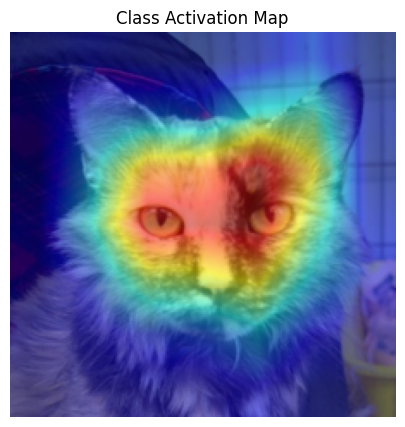

In [141]:
# Image to show-------------------------------------------------
image_path = proj_dir + "/Datasets/kagglecatsanddogs_5340/PetImages/Cat/10.jpg"

# Load the image with PIL
image = Image.open(image_path)
input_tensor = transform(image) #input_tensor = torch.randn(1, 3, 224, 224)
image = image.resize((224, 224))
image = image.convert('RGB')

# to np array
image_np = np.array(image)
image_np = image_np.astype(np.float32)
image_np /= 255.0

# CAM------------------------------------------------------------
# last layer that will be used for generating the CAM
target_layers = [model._blocks[-1]]

cam = GradCAM(model=model, target_layers=target_layers)

target_category = None  # Or specify the class you want to visualize
grayscale_cam = cam(input_tensor.unsqueeze(0), target_category)  # Add batch dimension
grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

# Vizualization---------------------------------------------------
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.imshow(visualization)  # Show the image
plt.axis('off')  # Hide axes
plt.title('Class Activation Map')  # Optional: add a title
plt.show()

# Maybe will be useful later

In [ ]:
# Observe images in the folder

dataset_dir = proj_dir + '/Datasets/kagglecatsanddogs_5340/PetImages' # was initially downloaded from Microsoft site

# Cats
rdm_img_list = glob.glob(os.path.join(dataset_dir + "/Cat",'*.jpg'))
random_idx = np.random.randint(1, len(rdm_img_list), size=9)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(rdm_img_list[idx])
    ax.imshow(img)

# Model info
'''
summary(model, (3, 224, 224))

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]}")  # prints first 2 values of the layer weights

for name, layer in model.named_children():
    print(f"Layer: {name}")
    for param_name, param in layer.named_parameters(recurse=False):
        print(f"  Parameter: {param_name}, Shape: {param.size()}")'''